# Zeroshot Classification

This notebook describes how we applied zero-shot classification using the OpenCLIP model.

In [ ]:
!pip install open_clip_torch

In [ ]:

import open_clip
from tqdm import tqdm
import pandas as pd
import torch
import os
import numpy as np
import pickle
import math
from collections import Counter

from google.colab import drive

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score

tqdm.pandas()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

## Load model

In [ ]:
model, transform, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

## Load image embedddings and labels

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = '/content/drive/MyDrive/dating-images'
data_folder = root_dir + '/data/'
out_folder = root_dir + '/output/'
fig_folder = root_dir + '/figures/'

In [ ]:
# helpers to load and save pickle and json files

def loadPKL(path):
  infile = open(path,'rb')
  X = pickle.load(infile)
  print('Loaded ' + path.split('/')[-1])
  return X

def savePKL(data, path):
  with open(path, 'wb') as f:
    pickle.dump(data, f)
  print('Saved ' + path.split('/')[-1])

def loadJSON(path):
  infile = open(path,'rb')
  X = json.load(infile)
  print('Loaded ' + path.split('/')[-1])
  return X

def saveJSON(data, path):
  with open(path, 'w') as jsonfile:
    json.dump(data, jsonfile)
  print('Saved ' + path.split('/')[-1])

### De Boer Scene Detection

In [ ]:
df = pd.read_json(data_folder + 'image_data.json')
df.columns = ['path', 'date', 'year', 'scene', 'set']

In [ ]:
X_ = loadPKL(data_folder + 'embeddings.pkl')
X_color = loadPKL(data_folder + 'embeddings_colorized.pkl')
df['embeddings'] = X_
df['embeddings_color'] = X_color



Loaded embeddings.pkl
Loaded embeddings_colorized.pkl


In [ ]:
test_set = df[df['set'] == 'test']
test_set.shape[0]

7974

In [ ]:
test_set

,path,date,year,scene,n_people,set,embeddings,embeddings_color
5,../scene_detection/images/group_portrait/NL-Hl...,09-04-1954,1954,group_portrait,27,test,"[-0.13827316, -0.09693622, 0.7175596, 1.262304...","[0.03307308, 0.012412988, 0.8029267, 0.6781997..."
10,../scene_detection/images/group_portrait/NL-Hl...,20-09-1991,1991,group_portrait,17,test,"[-0.3558416, 0.053709447, 0.38791674, 1.190288...","[-0.19344053, 0.32668668, 0.21820244, 1.302517..."
11,../scene_detection/images/soccer/NL-HlmNHA_147...,05-03-1972,1972,soccer,21,test,"[-0.3583753, -0.034836248, 0.0031666383, 0.357...","[-0.4921596, -0.07365929, -0.09223172, -0.2199..."
16,../scene_detection/images/saint_niclaus/NL-Hlm...,22-11-1986,1986,saint_niclaus,21,test,"[-0.142195, 0.059297107, -0.21131043, 0.425397...","[-0.035523817, 0.14763325, -0.21782216, 0.3563..."
17,../scene_detection/images/playground/NL-HlmNHA...,02-07-1984,1984,playground,0,test,"[0.18217465, 0.07113363, 0.078862436, 1.117787...","[0.054049373, 0.2506406, 0.18072516, 0.7526613..."
...,...,...,...,...,...,...,...,...
39855,../scene_detection/images/welcome_goodbye/NL-H...,30-12-1968,1968,welcome_goodbye,7,test,"[0.2281032, 0.2924334, 0.5269641, 0.38330734, ...","[0.19431923, 0.2023839, 0.14756694, 0.33915988..."
39858,../scene_detection/images/building/NL-HlmNHA_1...,26-01-1978,1978,building,1,test,"[-0.14144965, -0.08033691, 0.1497427, 0.692440...","[0.13929616, 0.096111074, -0.025540592, 0.4223..."
39859,../scene_detection/images/animals_misc/NL-HlmN...,22-07-1975,1975,animals_misc,0,test,"[0.2987152, -0.4919109, 0.5325819, 0.7818612, ...","[0.16724454, -0.14780383, 0.5644121, 0.7680996..."
39862,../scene_detection/images/dancing/NL-HlmNHA_14...,13-10-1989,1989,dancing,11,test,"[-0.3231623, -0.14045657, 0.32175204, 1.446891...","[-0.10675989, 0.26320004, 0.11798705, 1.160456..."


## Using existing embeddings

### Make predictions

In [ ]:
def make_prediction(df, text_features, X):
    true_label = df['year']
    scene = df['scene']
    embedding = df[X]
    image_features = torch.from_numpy(embedding).to(device)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity.topk(1)

    prediction = [years[indices], np.round(values.item(), 3), true_label, scene]
    return prediction

years = range(1950, 2000, 1)
text_inputs = tokenizer([f"a photograph from the year {c}" for c in years]).to(device)

with torch.no_grad(): #took this out of prediction function, this speeds it up considerably
  text_features = model.encode_text(text_inputs)

#### For a single image

In [ ]:
print(make_prediction(test_set.iloc[50], text_features, 'embeddings'))

[1960, 0.087, 1953, 'ceremony']


Here the model predicts that an image from 1953 in the category 'ceremony' as being rom the 1960 with a .087 accuracy.

In [ ]:
def calculate_mae(predictions):
  y_pred = [int(_[0]) for _ in predictions]
  y_true = [_[2] for _ in predictions]
  mae = np.mean(np.abs(np.array(y_true)-np.array(y_pred)))
  print(f'mean average error: {np.round(mae, 2)}')
  error_df = pd.DataFrame({"true_year": y_true, "predicted_year": y_pred, "error":np.array(y_pred)-np.array(y_true), "abs_error": abs(np.array(y_pred)-np.array(y_true)), "scene": list(zip(*predictions))[3]})
  return mae, error_df


#### Prediction for BW

In [ ]:
if os.path.exists(out_folder + 'zeroshot.pkl'):
  predictions = loadPKL(out_folder + 'zeroshot.pkl')
else:
  predictions = []

  predictions = test_set.progress_apply(make_prediction, args=[text_features, 'embeddings'], axis=1).tolist()

  savePKL(predictions, out_folder + 'zeroshot.pkl')

Loaded zeroshot.pkl


In [ ]:
print(Counter(list(zip(*predictions))[0]))

Counter({1964: 888, 1955: 727, 1954: 585, 1950: 568, 1972: 557, 1952: 487, 1965: 358, 1966: 341, 1960: 294, 1994: 244, 1974: 197, 1968: 166, 1956: 159, 1962: 147, 1959: 145, 1976: 142, 1992: 140, 1975: 125, 1969: 109, 1995: 108, 1984: 106, 1993: 105, 1958: 104, 1957: 104, 1988: 103, 1970: 91, 1997: 84, 1980: 78, 1978: 75, 1982: 74, 1951: 71, 1998: 64, 1967: 64, 1977: 63, 1996: 45, 1981: 35, 1973: 33, 1963: 23, 1971: 22, 1983: 19, 1989: 19, 1990: 18, 1999: 15, 1961: 13, 1953: 13, 1985: 13, 1986: 12, 1991: 9, 1979: 9, 1987: 3})


In [ ]:
mae_bw, error_df_bw = calculate_mae(predictions)

mean average error: 15.8


#### Prediction for Color

In [ ]:
if os.path.exists(out_folder + 'zeroshot_color.pkl'):
  predictions_color = loadPKL(out_folder + 'zeroshot_color.pkl')
else:
  predictions_color = []

  predictions_color = test_set.progress_apply(make_prediction, args=[text_features, 'embeddings_color'], axis=1).tolist()

  savePKL(predictions, out_folder + 'zeroshot.pkl')

100%|██████████| 7974/7974 [00:06<00:00, 1153.76it/s]

Saved file


In [ ]:
mae_colorized, error_df_colorized = calculate_mae(predictions_color)

mean average error: 13.18


In [ ]:
import scipy

### Plot histogram of errors for gray-scale and color predictions


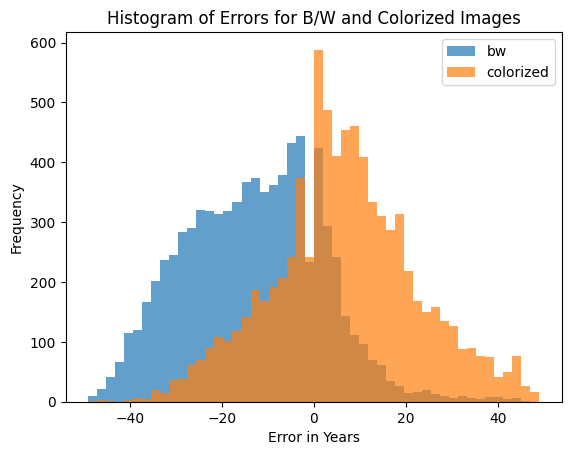

In [ ]:
df_error_bars = pd.DataFrame({'bw': error_df_bw['error'], 'colorized': error_df_colorized['error']})

ax = df_error_bars.plot.hist(alpha=0.7, bins=50)

ax.set_xlabel('Error in Years')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Errors for B/W and Colorized Images')


plt.savefig(fig_folder + 'zeroshot_histogram.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
df_error_bars

,bw,colorized
0,7,43
1,-27,5
2,-8,22
3,-26,8
4,-29,11
...,...,...
7969,-4,2
7970,-13,16
7971,19,19
7972,-17,10


In [ ]:
from scipy import stats
# Perform the two-sample K-S test
ks_statistic, p_value = stats.ks_2samp(df_error_bars['bw'], df_error_bars['colorized'])

print('K-S statistic:', ks_statistic)
print('p-value:', p_value)

from scipy.stats import skew

print(skew(df_error_bars['bw']))
print(skew(df_error_bars['colorized']))

K-S statistic: 0.4919739152244796
p-value: 0.0
0.16791469943614673
0.07990128138631951


## prediction on everything

In [ ]:
predictions = []
predictions_color = []

predictions = df.progress_apply(make_prediction, args=[text_features, 'embeddings'], axis=1).tolist()
predictions_color = df.progress_apply(make_prediction, args=[text_features, 'embeddings_color'], axis=1).tolist()


100%|██████████| 39866/39866 [00:14<00:00, 2834.40it/s]


In [ ]:
predicted_years_bw = [x[0] for x in predictions]
predicted_years_colorized = [x[0] for x in predictions_color]

In [ ]:
df['predicted_year_bw'] = predicted_years_bw
df['predicted_year_colorized'] = predicted_years_colorized

In [ ]:
df['error_bw'] = df['year'] - df['predicted_year_bw']
df['error_colorized'] = df['year'] - df['predicted_year_colorized']

In [ ]:
df[['year', 'scene', 'error_bw', 'error_colorized']].to_csv(out_folder + 'data_r.csv', index=False)